<h1 align="center">Natural Language Processing with Deep Learning Techniques - Project A</h1>
<h2 align="center">Nisim Machluf (301823472)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Yahav Cohen (207261983)</h2>


## Imports

In [25]:
import os
import csv
import json
import copy
import torch
import zipfile
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm
from itertools import product
from functools import partial
import matplotlib.pyplot as plt
from joblib import delayed, Parallel
from nltk.tokenize import TweetTokenizer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.feature_extraction.text import CountVectorizer
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import re
from sklearn.metrics import confusion_matrix
from matplotlib.ticker import PercentFormatter
from visualize_cv_results import *
from eda_functions import *
from visualize_eda import *
from visualize_train_results import *

In [2]:
DATA_FILES_PATH = "data"
EMBEDDINGS_PATH = "embeddings"

## df Creation

In [3]:
def create_df():
    csv_files = ["train.csv", "validation.csv"]

    if not all([os.path.isfile(os.path.join(DATA_FILES_PATH, f)) for f in csv_files]):
        with zipfile.ZipFile(os.path.join(DATA_FILES_PATH, "data.zip"), 'r') as z:
            z.extractall(DATA_FILES_PATH)
            print("Extracted Files:", ", ".join(z.namelist()))

    train_df = pd.read_csv(os.path.join(DATA_FILES_PATH, "train.csv"))
    test_df  = pd.read_csv(os.path.join(DATA_FILES_PATH, "validation.csv"))
    return train_df, test_df

    # labels are integers, comments are stringa
def process_data(df):
    df["text"] = df["text"].astype(str).str.lower().tolist()
    df["label"] = df["label"].astype(int).tolist()
    return df

train_df, test_df = create_df()
train_df = process_data(train_df)
test_df = process_data(test_df)

In [4]:
classes = {0: "Sadness",
           1: "Joy",
           2: "Love",
           3: "Anger",
           4: "Fear",
           5: "Surprise"}

## EDA

The graph below shows the class distribution to understand dataset balance and see which classes are more or less frequent.
The graph is normalized since the train includes more twetts.

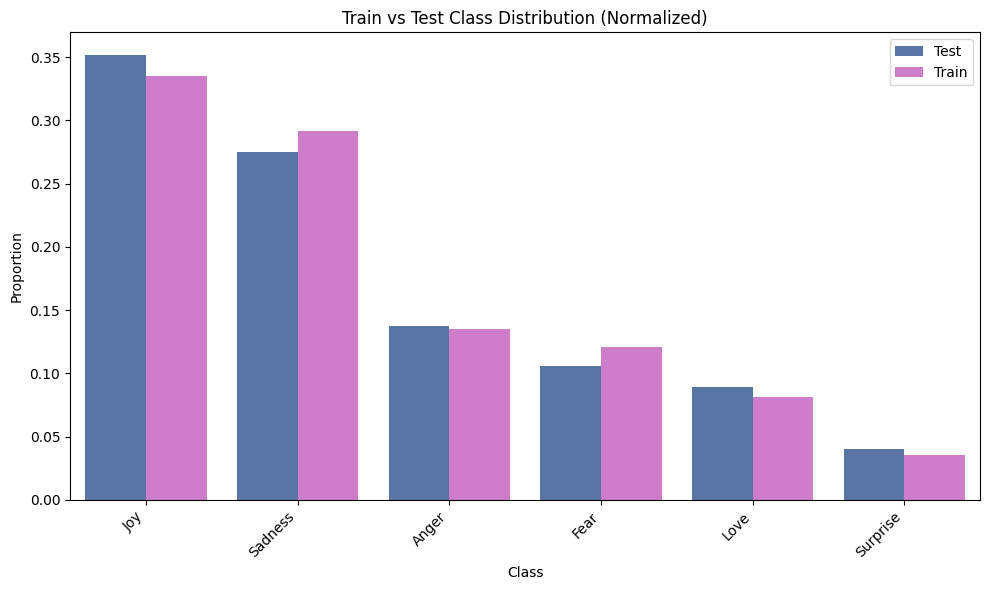

In [5]:
plot_class_distribution_compare(train_df, test_df, classes)

This graph shows the distribution of tweet lengths (in words) for the Train and Test datasets, normalized so the histograms are comparable despite different dataset sizes. Mean and std are added for each graph for comfort. Normalizing ensures differences in dataset size don't distort the comparison.

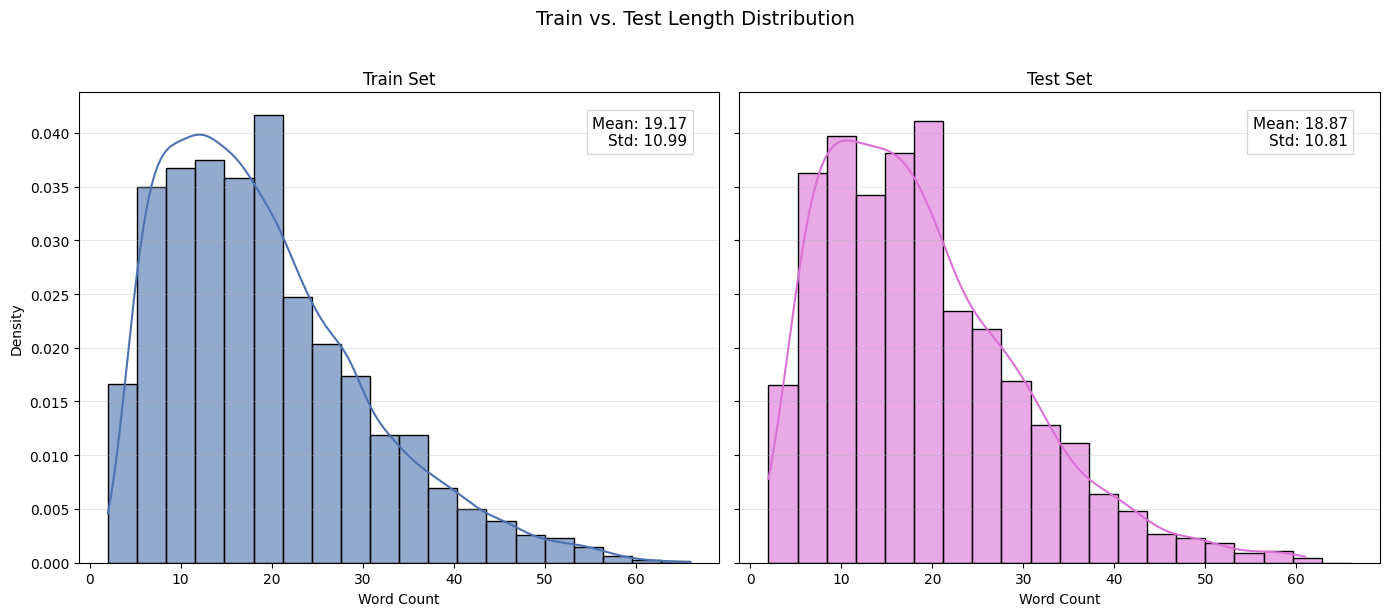

In [6]:
tweet_length_distribution_side_by_side(train_df, test_df)

We visualize the distribution of tweet lengths to understand the typical size of the texts in the dataset.
Later, when we perform cross-validation, this helps ensure that each fold has a balanced representation of text lengths across classes

We computed the most common unigrams and bigrams in the dataset to understand word usage and local context.


As we learned in class, these n-grams form the basis for many word embeddings such as Word2Vec and GloVe, which capture word co-occurrence patterns in dense vector form.

In [7]:
unigrarm(train_df, 5)
print('-----------------------------')
bigrams(train_df, 5)

The 5 most common words are:
like: 2908
so: 2527
but: 2255
was: 2227
have: 2224
-----------------------------
The 5 most common bigrams are:
feel like: 1744
im feeling: 801
to be: 785
to feel: 766
feel so: 757


In [8]:
most_common_words_per_class(train_df, classes, 2)

{'Sadness': [('like', 864), ('so', 826)],
 'Joy': [('like', 1006), ('have', 850)],
 'Love': [('like', 306), ('have', 196)],
 'Anger': [('like', 384), ('so', 338)],
 'Fear': [('about', 334), ('was', 306)],
 'Surprise': [('was', 112), ('so', 92)]}

In [9]:
linguistic_stats(train_df, classes)

,n_words,n_chars
label_name,,
Anger,19.229736,96.911533
Fear,18.844605,96.123903
Joy,19.498135,98.554457
Love,20.700153,104.033742
Sadness,18.361980,92.550579
Surprise,19.970280,101.676573


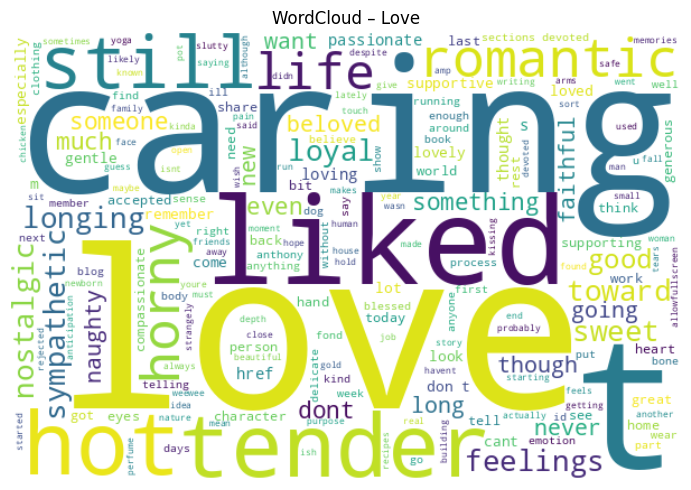

In [10]:
#example for 'suprise' class
wordcloud_for_class(test_df, classes,2)

## Data Processing

### Tokenize
We use an off-the-shelf tokenizer from the nltk library that was trained on tweets.

In [11]:
tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True)
train_df["tokens"] = train_df["text"].apply(tokenizer.tokenize)
test_df["tokens"] = test_df["text"].apply(tokenizer.tokenize)

### Data stratification
For the purpose of cross-validation and validation during training we split the data to 5 stratified folds. The stratification is performed according to 2 indicators:
1. label - since the data is not balanced we stratify the training set accroding to the label of the tweet, resulting in the same class ratio in each fold.
2. text length - to prevent an outcome where short texts and long texts are in different folds.

We calculate the 10 deciles over all the text lenghts and assign each text the index of its decile. Then for each sample we crate a new descriptor of the form \<label\>_\<decile\> and stratify according to it.

In [12]:
from sklearn.model_selection import StratifiedKFold

def startify_n_folds(df, n_splits, random_state=42):
    def assign_percentiles(numbers):
        numbers = np.array(numbers)
        percentile_edges = np.percentile(numbers, np.arange(0, 101, 10))
        percentile_bins = np.digitize(numbers, percentile_edges, right=True)
        return np.clip(percentile_bins, 1, 10)

    def add_fold_column(df, n_splits=5, random_state=42):
        """Adds a 'fold' column (0-4) to the dataframe."""
        df = df.copy()
        df['_strat_label'] = df["label"].astype(str) + '_' + df["_len_group"].astype(str)
        df['fold'] = -1

        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

        for fold, (_, val_idx) in enumerate(skf.split(df, df['_strat_label'])):
            df.loc[df.index[val_idx], 'fold'] = fold

        return df.drop(columns=['_strat_label'])


    df["_len_group"]= assign_percentiles(df.tokens.apply(len))
    df = add_fold_column(df, n_splits, random_state)
    return df.drop(columns=["_len_group"])
train_df = startify_n_folds(train_df, 5)

### Embedding
We use GloVe embedding of different embedding dimensions. Mapping from tokens indices is done according to the embedding vocabulary instead of according to the train set (tokenized) vocabulary. This is because more test set tokens are missing from the training set vocabulary than they are missing from the embedding vocabulary.<br>
Tokens that are abscent from the embeddings vocabulary are replaced by the "unk" token.

In [13]:
def process_glove_batch(lines, start_idx, idx):
    """
    Process a batch of GloVe lines and populate dictionaries.

    Args:
        lines: List of text lines from GloVe file
        start_idx: Starting index for this batch
        token2idx: Dictionary to populate with token->index mappings
        idx2token: Dictionary to populate with index->token mappings
        embeddings: List to append embedding vectors to

    Returns:
        Number of successfully processed lines
    """
    processed_count = 0
    embeddings = []
    token2idx = {}
    idx2token = {}
    for i, line in enumerate(lines):
        parts = line.strip().split()
        if not parts:
            continue

        token = parts[0]
        try:
            vec = np.asarray(parts[1:], dtype="float32")
            idx = start_idx + i
            token2idx[token] = idx
            idx2token[idx] = token
            embeddings.append(vec)
            processed_count += 1
        except Exception as e:
            print("Skipping bad line")
            # Skip malformed lines
            continue

    return token2idx, idx2token, np.stack(embeddings, axis=0)


def GloVe_embedding(embedding_dim=200, batch_size=1000, n_jobs=40):

    # Glove embedding
    #glove_path = "glove.twitter.27B.100d.txt" #looks nice from kaggle, I will try the origin first

    #extract original GloVe
    glove_path = os.path.join(EMBEDDINGS_PATH, f"glove.6B.{embedding_dim}d.txt") #download the zip file and extract it manually cause it takes forever othewise
    print("Loading GloVe embeddings...")

    t0 = time()
    with open(glove_path, "r", encoding="utf8") as f:
        lines = f.readlines()
    print(f"Read {len(lines)} lines from {glove_path} in {time()-t0:.1f} seconds")

    tasks = [delayed(process_glove_batch)(lines[acc_batch:acc_batch+batch_size], acc_batch, idx) for idx, acc_batch in enumerate(range(0, len(lines), batch_size))]
    results = Parallel(n_jobs=n_jobs)(tasks)

    embeddings = []
    token2idx = {}
    idx2token = {}

    for t2i, i2t, emb in results:
        embeddings.append(emb)
        token2idx.update(t2i)
        idx2token.update(i2t)

    print(f"Built embedding matrix in {time()-t0:.1f} seconds")
    return token2idx, idx2token, np.concatenate(embeddings, axis=0)

def tokens_to_ids(tokens, vocab, unk_token="unk"):
    unk_idx = vocab[unk_token]
    return [vocab.get(tok, unk_idx) for tok in tokens]

### DataLoader
Tweets are represented by a sequences of the embedding indices that correspond to their tokens. They are batched and padded to the length of the longest using the token index that correspond to the "pad" token.<br>
We recognize that this is suboptimal as "pad" is and actual word but we believe that this will have a negligible effect as we believe that it wll not apear a lot in the the tweets data.

In [14]:
class RNNDataSet(Dataset):
    def __init__(self, tweets, labels):
        self.tweets = tweets
        self.labels = labels

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        seq = torch.tensor(self.tweets[idx], dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return seq, label


def collate_fn(batch, token_id):
    pad_idx = token_id["pad"]
    seqs, labels = zip(*batch)
    seqs = pad_sequence(seqs, batch_first=True, padding_value=pad_idx)
    labels = torch.stack(labels)
    return seqs, labels

In [15]:
def create_dataloaders(train_df, test_df, token_id, fold=0, batch_size=32):
    if "token_ids" not in train_df.columns:
        train_df["token_ids"] = train_df.tokens.apply(lambda x: tokens_to_ids(x, token_id))
    if "token_ids" not in test_df.columns:
        test_df["token_ids"] = test_df.tokens.apply(lambda x: tokens_to_ids(x, token_id))

    train_folds = train_df.loc[train_df.fold != fold]
    val_fold = train_df.loc[train_df.fold == fold]

    train_dataset = RNNDataSet(train_folds["token_ids"].tolist(), train_folds["label"].tolist())
    val_dataset = RNNDataSet(val_fold["token_ids"].tolist(), val_fold["label"].tolist())
    test_dataset = RNNDataSet(test_df["token_ids"].tolist(), test_df["label"].tolist())

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=partial(collate_fn, token_id=token_id)
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=partial(collate_fn, token_id=token_id)
  )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=partial(collate_fn, token_id=token_id)
  )
    return train_loader, val_loader, test_loader


We will check the data imbalance

## RNN Model
We implement a simple classification model that is built from a single recurrent layer (LSTM or GRU) with configurable layer width and embedding dimensions.<br>
The recurrent layer is followed by a projecting FF layer that predicts the logits for the classification according to the number of classes.

In [16]:
class RNNClassifier(nn.Module):
    def __init__(self, token_id_size, embed_dim, hidden_dim, num_classes, embedding_matrix, model_class="lstm"):
        super().__init__()
        self.model_class = model_class.lower()
        self.embedding = nn.Embedding(token_id_size, embed_dim)
        print(f"constructing an embedding layer of size: {token_id_size}x{embed_dim}")
        print(f"loading weight of shape {embedding_matrix.shape}")
        self.embedding.weight.data.copy_(torch.tensor(embedding_matrix))
        self.embedding.weight.requires_grad = False
        if self.model_class == "lstm":
            self.rnn = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        elif self.model_class == "gru":
            self.rnn = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        else:
            raise ValueError(f"Un supported model class {model_class}. Available model classes are LSTM and GRU")
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        rnn_out = self.rnn(x)
        if self.model_class == "lstm":
            out, (h, c) = rnn_out
        else:
            out, h = rnn_out
        logits = self.fc(h[-1])
        return logits

## Training Helpers
We implement the following functions:
1. train_rnn - runs a full training procedure and returns the loss and accuracy for both the training and validation sets as well as the trained model an the best model seen during training in terms of validation accuracy.
2. compute_accuracy - given a model and dataloader computes the average accuracy and loss over the dataset.
3. AccuracyAccumulator/LossAccumulator - compute the running loss/accuracy during training/testing

In [17]:
class AccuracyAccumulator:
    def __init__(self):
        self.total = 0
        self.correct = 0

    def __call__(self, logits, labels):
        preds = torch.argmax(logits, dim=1)
        corrects = preds == labels
        self.correct += corrects.sum().item()
        self.total += labels.size(0)
        return self.correct/self.total, corrects, preds

class LossAccumulator:
    def __init__(self, loss_fn):
        self.loss_fn = loss_fn
        self.loss = 0
        self.total = 0

    def __call__(self, logits, labels):
        loss = self.loss_fn(logits, labels)
        self.loss += loss.item()
        self.total += 1
        return loss, self.loss/self.total

def compute_accuracy(model, dataloader, loss_fn=None):
    acc_acc = AccuracyAccumulator()
    if loss_fn:
        loss_acc = LossAccumulator(loss_fn)
    model.eval()
    device = next(model.parameters()).device
    preds = []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            acc, batch_corrects, batch_preds = acc_acc(logits, y)
            preds.extend(batch_preds.cpu().numpy().tolist())
            if loss_fn:
                _, loss = loss_acc(logits, y)
    if loss_fn:
        return acc, loss, preds
    return acc, preds

def train_rnn(train_loader, val_loader, vocab_size, embed_dim, hidden_dim, embedding_matrix, num_epochs, path=None, device='cuda', verbose=True, model_class="lstm"):
    model = RNNClassifier(vocab_size, embed_dim, hidden_dim, 6, embedding_matrix, model_class=model_class).to(device)
    loss_objective = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    train_losses, train_accuracies, val_losses, val_accuracies= [], [], [], []

    if path is not None:
        csv_path = f'{path}.csv'

    best_val_acc = 0
    best_model_state = None
    print(f"Training model with hyperparameters: embed_dim={embed_dim}, hidden_dim={hidden_dim}, num_epochs={num_epochs}")
    for epoch in range(num_epochs):
        model.train()
        train_acc_acc = AccuracyAccumulator()
        train_loss_acc = LossAccumulator(loss_objective)
        if verbose:
            loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        else:
            loop = train_loader

        for inputs, labels in loop:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            logits = model(inputs)
            train_acc, _, _ = train_acc_acc(logits, labels)
            loss, epoch_loss = train_loss_acc(logits, labels)
            loss.backward()
            optimizer.step()
            if verbose: loop.set_postfix(loss=loss.item())

        train_losses.append(epoch_loss)
        train_accuracies.append(train_acc)
        val_acc, val_loss, _ = compute_accuracy(model, val_loader, loss_objective)
        val_accuracies.append(val_acc)
        val_losses.append(val_loss)
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
        if path is not None:
            with open(csv_path, 'a', newline='') as f: # in case we will want to change the grpah without retraining
                writer = csv.writer(f)
                writer.writerow([epoch+1, epoch_loss, val_acc])
        if verbose:
            print(f"Train Accuracy: {train_acc*100:.2f} | Validation Acc={val_acc * 100:.2f}")
    if path is not None:
        torch.save(model.state_dict(), path)

    best_model = RNNClassifier(vocab_size, embed_dim, hidden_dim, 6, embedding_matrix, model_class=model_class).to(device)
    _ = best_model.load_state_dict(best_model_state)
    return train_losses, train_accuracies, val_losses, val_accuracies, best_model, model

def report_training_results(last_model, best_model, loader):
    RESET = '\033[0m'
    BOLD = '\033[1m'
    last_acc, last_results = compute_accuracy(last_model, test_loader)
    best_acc, best_results = compute_accuracy(best_model, test_loader)
    tit = "Test Set Results:"
    print(BOLD+tit + "\n"+"="*len(tit)+RESET)
    print(f"The {BOLD}fully trained model{RESET} achieves {BOLD}{last_acc*100:.2f}%{RESET} accuracy.\nThe {BOLD}best model{RESET} seen during training achieves {BOLD}{best_acc*100:.2f}%{RESET} accuracy.")
    return last_results if last_acc < best_acc else best_results

## Cross Validation
We use different combinations of hidden layer width, embedding dimension and number of training epochs and use each configuration to train over 5 training set folds.

In [18]:
def cross_validate_grid_search(get_fold_loaders, param_grid, train_fn, n_folds=5, results_path='cv_results.json'):
    """
    Perform cross-validation with grid search over parameters.
    Saves/loads results from JSON file to resume interrupted runs.

    Args:
        get_fold_loaders: function(fold_num) -> (train_loader, val_loader)
        param_grid: dict of parameter names to lists of values
        train_fn: function(train_loader, val_loader, **params) -> val_metric
        n_folds: number of folds
        results_path: path to JSON file for saving/loading results

    Returns:
        dict with best_params, best_score, and all_results
    """
    # Load existing results if file exists
    if os.path.exists(results_path):
        with open(results_path, 'r') as f:
            saved_data = json.load(f)
            results = saved_data.get('all_results', [])
            print(f"Loaded {len(results)} existing results from {results_path}")
    else:
        results = []

    # Create set of already tested parameter combinations
    tested_params = {_params_to_key(r['params']) for r in results}

    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    param_combinations = list(product(*param_values))

    last_emb_dim = 0
    # Iterate over all parameter combinations
    skipped = 0
    for param_combo in param_combinations:
        params = dict(zip(param_names, param_combo))
        params_key = _params_to_key(params)

        # Skip if already tested
        if params_key in tested_params:
            skipped += 1
            continue

        fold_scores = []

        print(f"\nTesting params: {params}")
        embed_dim = params.get("embed_dim")
        if embed_dim != last_emb_dim:
            token_id, id_token, embedding_matrix = GloVe_embedding(embed_dim)
            last_emb_dim = embed_dim

        # Cross-validation across folds
        for fold in range(n_folds):
            train_loader, val_loader, _ = get_fold_loaders(token_id=token_id, fold=fold)
            train_fn_params = params.copy()
            train_fn_params.update({"vocab_size": embedding_matrix.shape[0],
                           "embedding_matrix": embedding_matrix})
            # Train and evaluate with current parameters
            _, _, _, val_scores, _, _ = train_fn(train_loader, val_loader, **train_fn_params)
            fold_scores.append(val_scores[-1])

            print(f"  Fold {fold+1}/{n_folds}: {fold_scores[-1]:.4f}")

        # Calculate mean and std across folds
        mean_score = np.mean(fold_scores)
        std_score = np.std(fold_scores)

        result = {
            'params': params,
            'mean_score': float(mean_score),
            'std_score': float(std_score),
            'fold_scores': [float(s) for s in fold_scores]
        }
        print(result)
        results.append(result)
        tested_params.add(params_key)

        print(f"  Mean: {mean_score:.4f} ± {std_score:.4f}")

        # Save results after each experiment
        _save_results(results_path, results)
        print(f"  Results saved to {results_path}")

    print(f"Found existing results for {skipped}/{len(param_combinations)} experimets (skipped)")
    # Find best parameters
    best_result = max(results, key=lambda x: x['mean_score'])

    final_results = {
        'best_params': best_result['params'],
        'best_score': best_result['mean_score'],
        'best_std': best_result['std_score'],
        'all_results': results
    }

    # Save final results
    _save_results(results_path, results, final_results)

    return final_results


def _params_to_key(params):
    """Convert params dict to a hashable key for comparison."""
    return tuple(sorted(params.items()))


def _save_results(results_path, results, final_results=None):
    """Save results to JSON file."""
    data = {
        'all_results': results
    }
    if final_results:
        data['best_params'] = final_results['best_params']
        data['best_score'] = final_results['best_score']
        data['best_std'] = final_results['best_std']

    with open(results_path, 'w') as f:
        json.dump(data, f, indent=2)

In [19]:
train_fn = partial(train_rnn, path=None, device='cuda', verbose=False, model_class="lstm")
param_grid = {"embed_dim": [100, 200, 300],
              "hidden_dim" : [128, 256, 512],
              "num_epochs" : [10, 15, 20]}
get_folds_fn = partial(create_dataloaders, train_df=train_df, test_df=test_df, batch_size=16)
results = cross_validate_grid_search(get_folds_fn, param_grid, train_fn)

Loaded 27 existing results from cv_results.json
Found existing results for 27/27 experimets (skipped)


## Cross Validation Results Analysis

### Plots

The following graph describes the mean accuracy over the CV folds with their corresponding standard deviations for each of the tested configurations. The best measured configuration is embedding size of 300, LSTM hidden layer of size 256 and training over 15 epochs. Nevertheless, the next best configurations demonstrate similar performance. Common factors for the best configurations are combinations of higher embedding dimensions (but mostly of size 300) and larger hidden layer width.

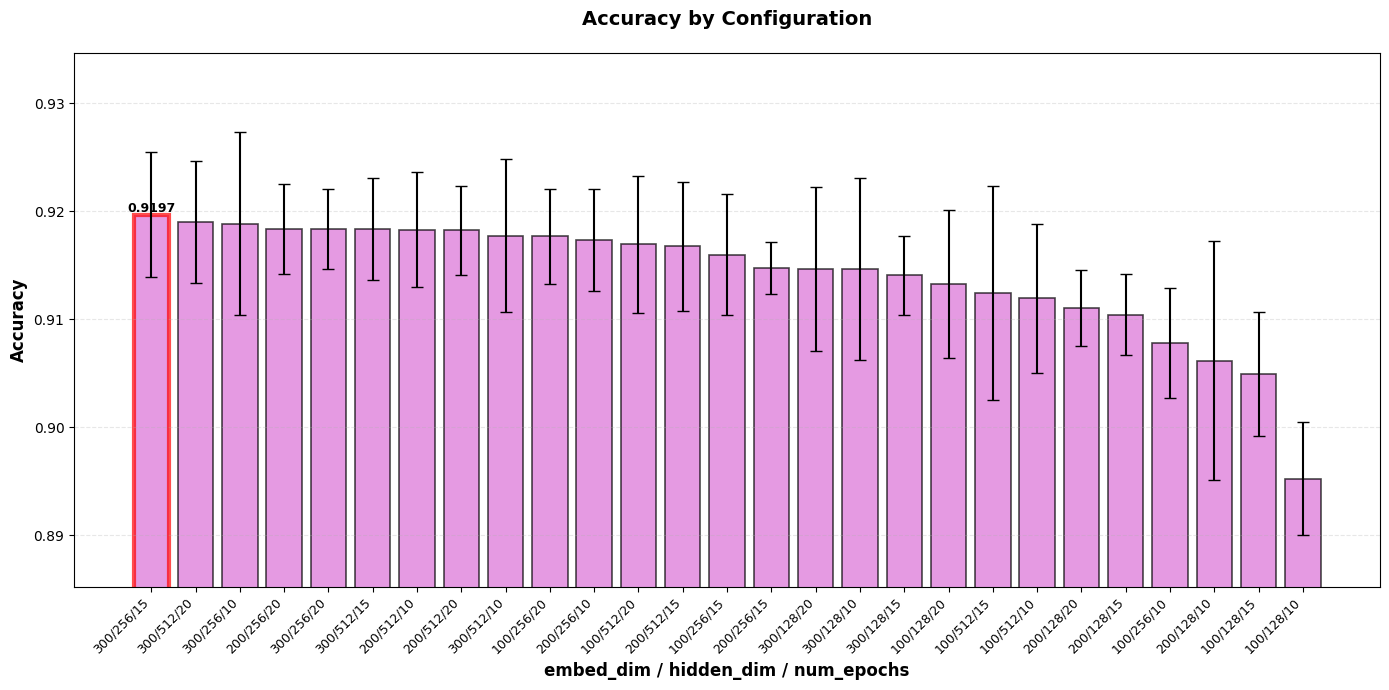

In [20]:
with open('cv_results.json', 'r') as f:
    results = json.load(f)
_ = plot_params_barplot(results, figsize=(14, 7))


The plots below show the mean accuracy by either the embedding dimension or the hidden layer width, where the mean is taken of the rest of the parameters in each case. On the left hand side side wecan see that the performance are gradually improving with the growth of the embedding dimension. On the right hand side, it is shown that using a hidden LSTM layer of width 512 is equivaluent to using a width of 256 but both perform better than using a width of 100. Thi suggests that for this specific task the performance is saturated at the width of 256 and adding more neurons will result in diminishing return.

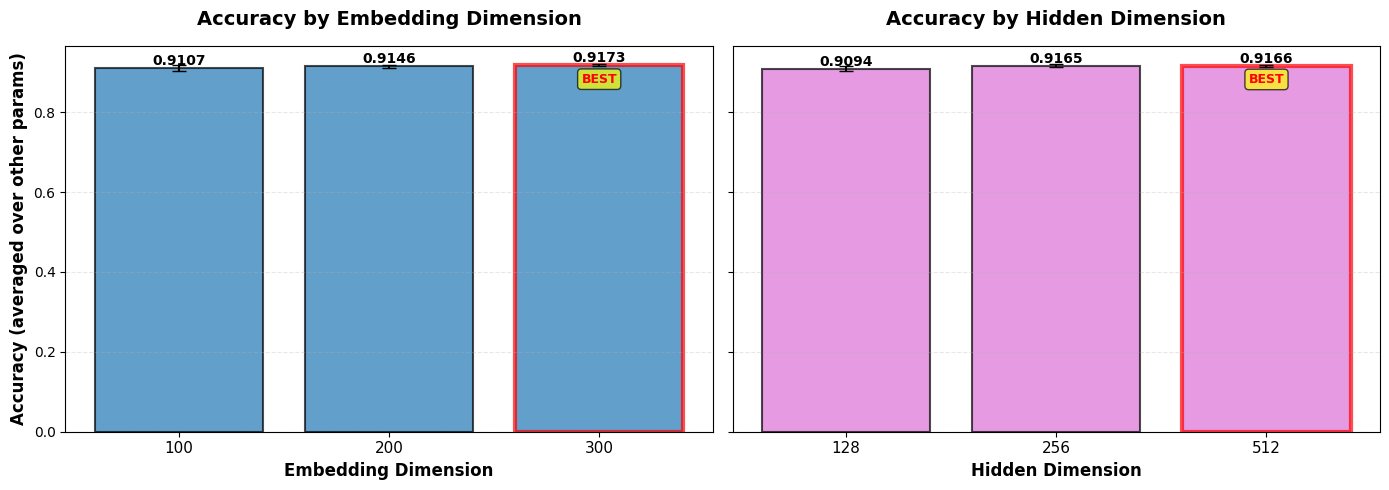

In [21]:
_ = plot_mean_scores_comparison(results, figsize=(14, 5))

This plot scatters the mean accuracy (over the CV folds) over the hidden layer width and the embedding size, where in each we show the result of the best epoch (marker shape) and where the score is color coded (brighter is better).
We can see that in most setups trainig for 20 epoch was more beneficial, although the best score was obtained for 15 epochs which can be considered to be withing error range. In addition, the plot demonstrated the diminishing returns of using wider hidden layer (colors dont change much when climbing the vertical axis), but using larger embedding dimensions is prefered.

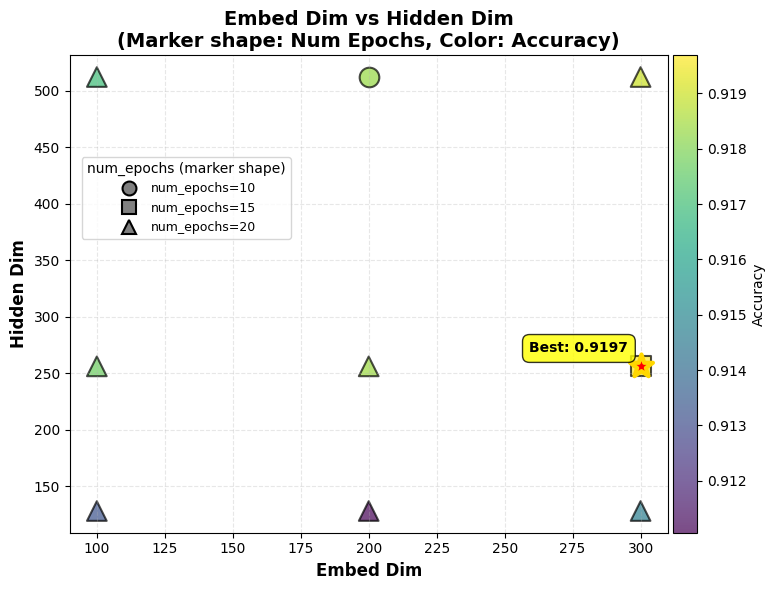

In [22]:
_ = plot_scatter_with_third_param(results, figsize=(8, 6))

## Train an LSTM Model
We select the best configuration and train the model over 15 epochs on an LSTM with a hidden layer of width 256 on word embedding of size 300.

In [23]:
embedding_dims = 300
hidden_dims = 256
num_epochs = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
token_id, id_token, embedding_matrix = GloVe_embedding(embedding_dims)
vocab_size = len(token_id)

train_loader, val_loader, test_loader = create_dataloaders(train_df, test_df, token_id, batch_size=16)
path = None #f'Gl_lstm_model_embed_{embedding_dims}_hidden_{hidden_dims}.pth'
lstm_train_losses, lstm_train_accuracies, lstm_val_losses, lstm_val_accuracies, lstm_best_model, lstm_last_model = train_rnn(train_loader, val_loader, vocab_size, embedding_dims, hidden_dims, embedding_matrix, num_epochs, path, device, verbose=True)

Loading GloVe embeddings...
Read 400000 lines from embeddings/glove.6B.300d.txt in 2.2 seconds
Built embedding matrix in 7.9 seconds
constructing an embedding layer of size: 400000x300
loading weight of shape (400000, 300)
Training model with hyperparameters: embed_dim=300, hidden_dim=256, num_epochs=15


Epoch 1/15: 100%|██████████| 800/800 [00:08<00:00, 97.47it/s, loss=1.6]  


Train Accuracy: 32.45 | Validation Acc=33.75


Epoch 2/15: 100%|██████████| 800/800 [00:07<00:00, 108.08it/s, loss=1.72]


Train Accuracy: 32.92 | Validation Acc=33.66


Epoch 3/15: 100%|██████████| 800/800 [00:07<00:00, 108.46it/s, loss=1.44] 


Train Accuracy: 44.06 | Validation Acc=63.41


Epoch 4/15: 100%|██████████| 800/800 [00:07<00:00, 110.36it/s, loss=0.404] 


Train Accuracy: 80.63 | Validation Acc=89.06


Epoch 5/15: 100%|██████████| 800/800 [00:07<00:00, 106.89it/s, loss=0.13]   


Train Accuracy: 92.38 | Validation Acc=90.47


Epoch 6/15: 100%|██████████| 800/800 [00:07<00:00, 109.77it/s, loss=0.19]   


Train Accuracy: 94.27 | Validation Acc=91.25


Epoch 7/15: 100%|██████████| 800/800 [00:07<00:00, 109.98it/s, loss=0.0123] 


Train Accuracy: 95.34 | Validation Acc=90.97


Epoch 8/15: 100%|██████████| 800/800 [00:07<00:00, 107.39it/s, loss=0.00333] 


Train Accuracy: 96.02 | Validation Acc=91.72


Epoch 9/15: 100%|██████████| 800/800 [00:07<00:00, 109.77it/s, loss=0.0251]  


Train Accuracy: 96.29 | Validation Acc=91.25


Epoch 10/15: 100%|██████████| 800/800 [00:07<00:00, 108.85it/s, loss=0.004]   


Train Accuracy: 96.84 | Validation Acc=91.31


Epoch 11/15: 100%|██████████| 800/800 [00:07<00:00, 104.90it/s, loss=0.0801]  


Train Accuracy: 97.33 | Validation Acc=91.06


Epoch 12/15: 100%|██████████| 800/800 [00:07<00:00, 109.56it/s, loss=0.014]   


Train Accuracy: 97.74 | Validation Acc=91.25


Epoch 13/15: 100%|██████████| 800/800 [00:07<00:00, 109.37it/s, loss=0.00054] 


Train Accuracy: 97.98 | Validation Acc=91.25


Epoch 14/15: 100%|██████████| 800/800 [00:07<00:00, 106.94it/s, loss=0.00211] 


Train Accuracy: 98.29 | Validation Acc=91.81


Epoch 15/15: 100%|██████████| 800/800 [00:07<00:00, 107.83it/s, loss=0.00374] 


Train Accuracy: 98.45 | Validation Acc=91.56
constructing an embedding layer of size: 400000x300
loading weight of shape (400000, 300)


### Loss/Accuracy Curves
The loss over both the training and validation set sharply decreases in the first epochs and the start to diverge, where the training loss keeps going down and the validation loss starting to reach a plateau. Similar observation can be made on the accuracy curves. The training routine returns both the model that was exhaustively trained and the model that acheived the best validation accuracy.

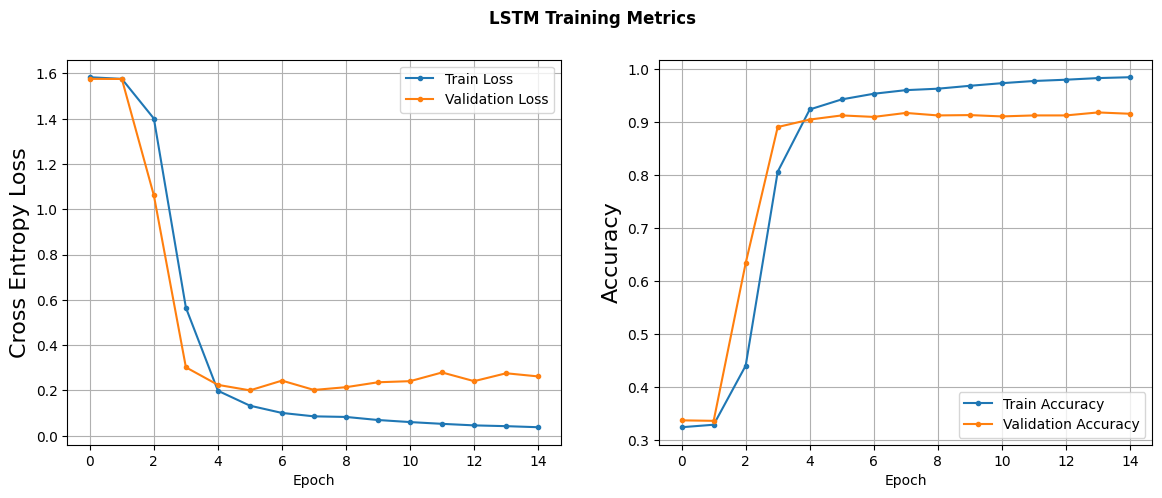

In [26]:
plot_training_progress(lstm_train_losses, lstm_val_losses, lstm_train_accuracies, lstm_val_accuracies, sup_tit="LSTM Training Metrics")

In [27]:
lstm_results = report_training_results(lstm_last_model, lstm_best_model, test_loader)

Test Set Results:
The fully trained model achieves 93.15% accuracy.
The best model seen during training achieves 93.05% accuracy.


### Confusion matrix
Examining the confusion matrix we see that even when the model misclassified tweets, the predictions can be reasoned. For example, only a handful of texts where of positive/negative feelings and were classified as negative/positive. Most of the mistakes were between Love and Joy and Anger and Fear.

10 Examples of Misclassification

Ground Truth    Prediction      Text
--------------------------------------------------------------------------------------------------------------
Fear            Sadness         i so desperately want to be able to help but i feel so helpless
Love            Joy             i feel god calling me there and if he wills it i ll be a priest for him and t...
Sadness         Anger           i feel hated there but had to remind my selfish self that none of this was ab...
Sadness         Joy             i arrived home with a strange feeling of happiness and discontent
Fear            Anger           i feel so tortured by it
Joy             Love            i have stayed at heritage christian because of the fulfillment that i feel in...
Love            Joy             i cant stop the joyful tears from flowing as i feel this sweet baby moving
Love            Joy             i feel gracious what about you
Love            Sadness         i party darling don t clos

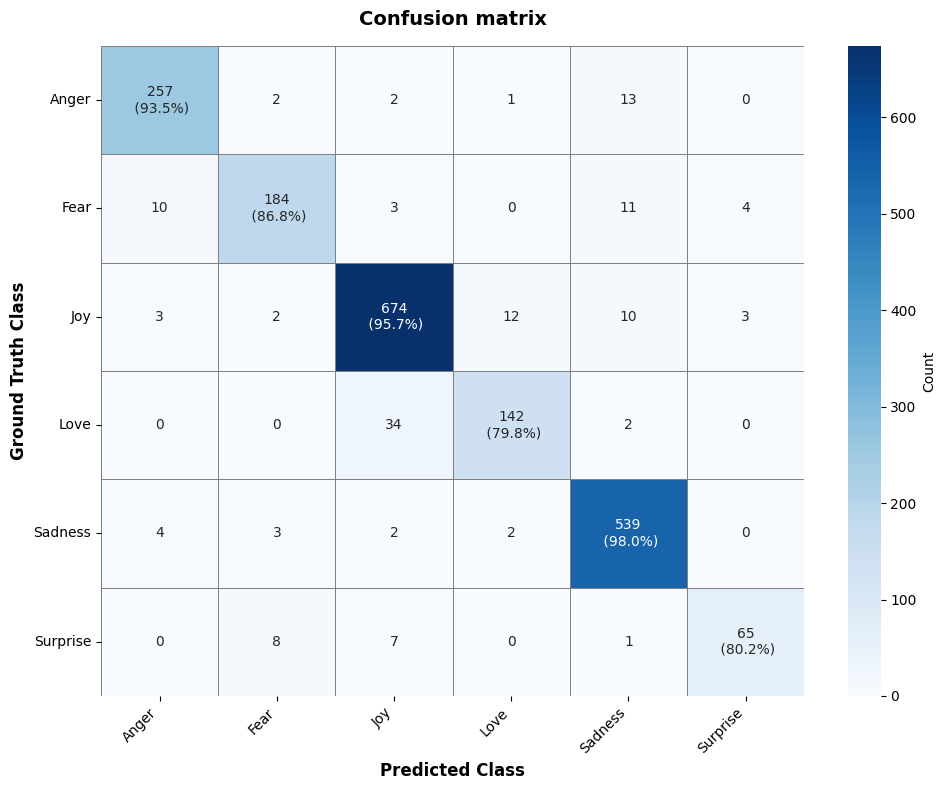

In [28]:
err_samples = plot_confusion_matrix(test_df, lstm_results, classes)
print_predictions(err_samples)

## Trying GRU
For completeness we compare the results of a GRU with the same parameters that were used for the LSTM


In [29]:
gru_train_losses, gru_train_accuracies, gru_val_losses, gru_val_accuracies, gru_best_model, gru_last_model = train_rnn(train_loader, val_loader, vocab_size, embedding_dims,
                                                                                                                        hidden_dims, embedding_matrix, num_epochs, path, device, verbose=True, model_class="gru")

constructing an embedding layer of size: 400000x300
loading weight of shape (400000, 300)
Training model with hyperparameters: embed_dim=300, hidden_dim=256, num_epochs=15


Epoch 1/15: 100%|██████████| 800/800 [00:07<00:00, 107.25it/s, loss=0.54]  


Train Accuracy: 58.91 | Validation Acc=85.97


Epoch 2/15: 100%|██████████| 800/800 [00:07<00:00, 103.52it/s, loss=0.636] 


Train Accuracy: 90.46 | Validation Acc=89.22


Epoch 3/15: 100%|██████████| 800/800 [00:07<00:00, 106.90it/s, loss=0.0939] 


Train Accuracy: 93.35 | Validation Acc=90.75


Epoch 4/15: 100%|██████████| 800/800 [00:07<00:00, 108.03it/s, loss=0.244]   


Train Accuracy: 94.82 | Validation Acc=91.00


Epoch 5/15: 100%|██████████| 800/800 [00:07<00:00, 111.71it/s, loss=0.0344]  


Train Accuracy: 95.67 | Validation Acc=91.97


Epoch 6/15: 100%|██████████| 800/800 [00:07<00:00, 110.20it/s, loss=0.0747]  


Train Accuracy: 96.48 | Validation Acc=91.72


Epoch 7/15: 100%|██████████| 800/800 [00:07<00:00, 108.98it/s, loss=0.0379]  


Train Accuracy: 96.92 | Validation Acc=91.25


Epoch 8/15: 100%|██████████| 800/800 [00:07<00:00, 107.29it/s, loss=0.0252]  


Train Accuracy: 97.70 | Validation Acc=91.19


Epoch 9/15: 100%|██████████| 800/800 [00:07<00:00, 109.62it/s, loss=0.00779] 


Train Accuracy: 98.39 | Validation Acc=91.25


Epoch 10/15: 100%|██████████| 800/800 [00:07<00:00, 109.04it/s, loss=0.0331]  


Train Accuracy: 99.08 | Validation Acc=91.31


Epoch 11/15: 100%|██████████| 800/800 [00:07<00:00, 105.52it/s, loss=0.00374] 


Train Accuracy: 98.81 | Validation Acc=91.19


Epoch 12/15: 100%|██████████| 800/800 [00:07<00:00, 104.76it/s, loss=0.00187] 


Train Accuracy: 99.00 | Validation Acc=91.25


Epoch 13/15: 100%|██████████| 800/800 [00:07<00:00, 107.63it/s, loss=0.00221] 


Train Accuracy: 99.24 | Validation Acc=91.53


Epoch 14/15: 100%|██████████| 800/800 [00:07<00:00, 108.63it/s, loss=0.000214]


Train Accuracy: 99.41 | Validation Acc=91.12


Epoch 15/15: 100%|██████████| 800/800 [00:07<00:00, 107.82it/s, loss=0.0402]  


Train Accuracy: 99.42 | Validation Acc=91.75
constructing an embedding layer of size: 400000x300
loading weight of shape (400000, 300)


From the loss and accuracy curves we can see that the GRU architecture is much more efficient than the LSTM and trains much faster. In fact, we could have stopped the training in less than a few epochs. 

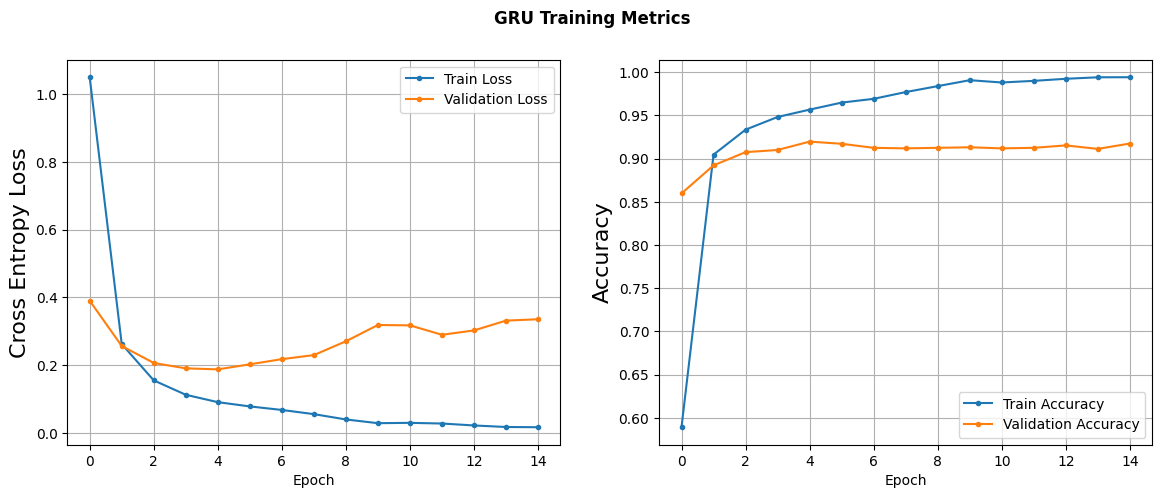

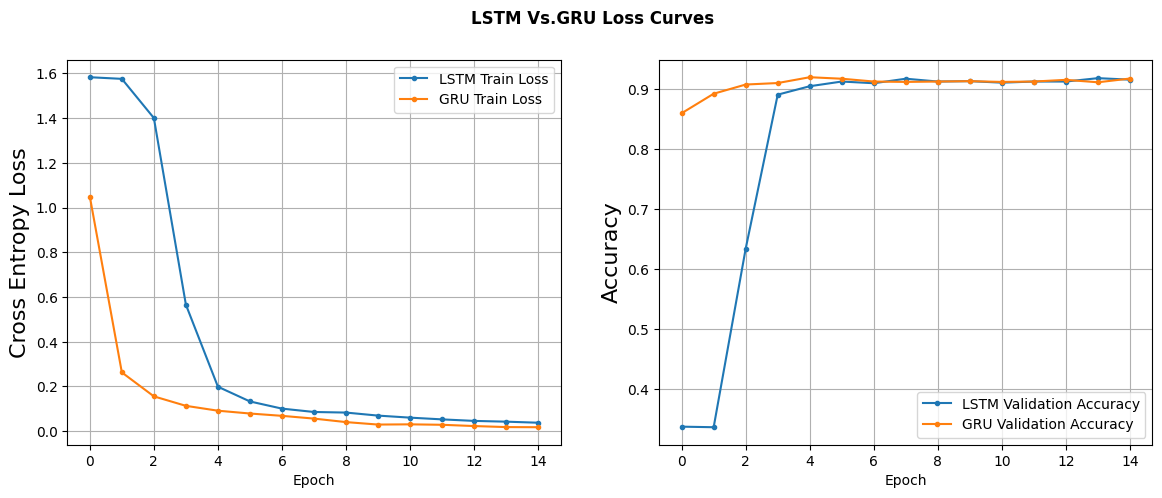

In [30]:
plot_training_progress(gru_train_losses, gru_val_losses, gru_train_accuracies, gru_val_accuracies, sup_tit="GRU Training Metrics")
plot_training_progress(lstm_train_losses, gru_train_losses, lstm_val_accuracies, gru_val_accuracies, sup_tit="LSTM Vs.GRU Loss Curves", labels=["LSTM Train Loss", "GRU Train Loss",
                                                                                                                                        "LSTM Validation Accuracy", "GRU Validation Accuracy"])


In terms of accuracy performance, the GRU is comparable to the LSTM on <b> this task</b>.<br>
The GRU makes mistakes similar to the LSTM's as evident from the confusion matrix.

In [31]:
gru_results = report_training_results(gru_best_model, gru_last_model, test_loader)

Test Set Results:
The fully trained model achieves 92.25% accuracy.
The best model seen during training achieves 92.30% accuracy.


10 Examples of Misclassification

Ground Truth    Prediction      Text
--------------------------------------------------------------------------------------------------------------
Surprise        Joy             i feel so amazing about taking this trip as i think ill finally be able to re...
Joy             Surprise        i don t hug my family i usually don t hug my friends there are only a few peo...
Fear            Anger           i was feeling much more agitated than usual had difficulties sleeping and con...
Sadness         Fear            i feel worthless confused edgy and mentally drained
Love            Joy             im feeling generous today oh man all of my fave clothing items are going to b...
Love            Joy             i feel a sort of sweet relief when i look around and realize that or house lo...
Joy             Love            i am still setting myself the challenge of painting roses in a way that i fee...
Surprise        Sadness         i as representative of e

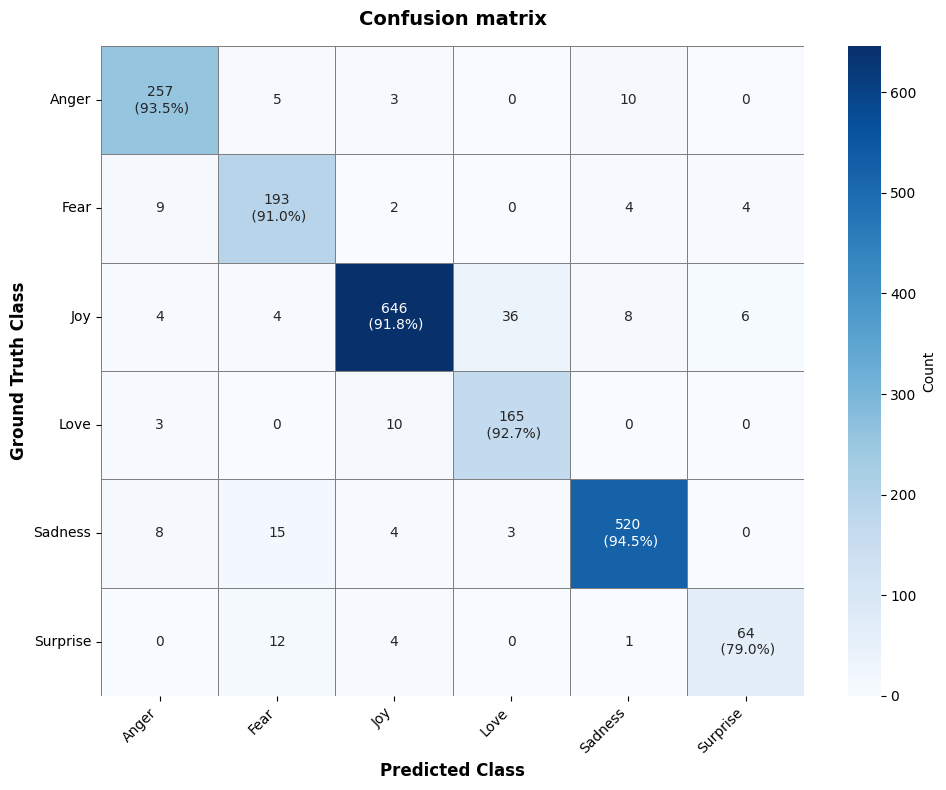

In [32]:
err_samples = plot_confusion_matrix(test_df, gru_results, classes=classes)
print_predictions(err_samples)

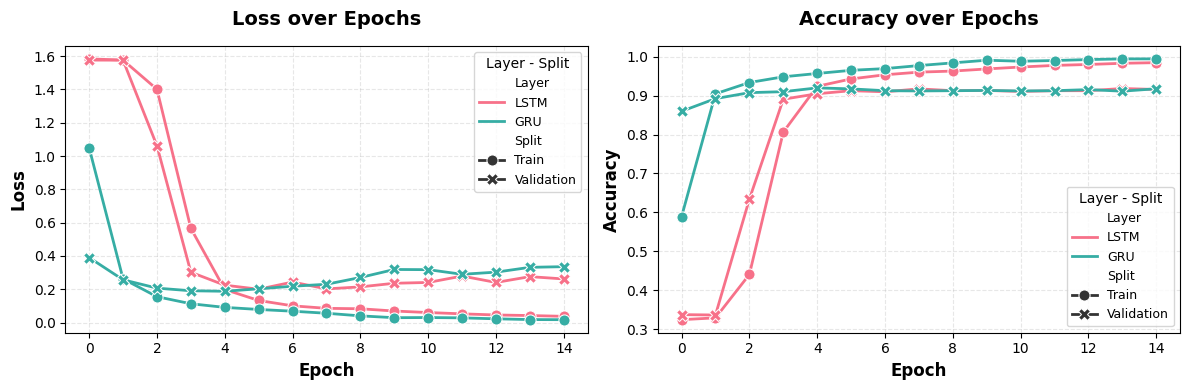

In [41]:
_ = plot_layer_metrics_seaborn(df, figsize=(12, 4))